# Collegedunia -  Data Analysis Assesment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point
from sklearn.impute import KNNImputer
from geopy.distance import geodesic


# User Behaviour Analysis:
# Use events.csv to analyse user behaviour, including session patterns, traffic sources, and event types.

In [2]:
events = pd.read_csv('./data/events.csv')

In [3]:
events.shape

(2431963, 13)

In [4]:
events.head()

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,2198523,NaN,3,83889ed2-2adc-4b9a-af5d-154f6998e778,2021-06-17 17:30:00+00:00,138.143.9.202,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
1,1773216,NaN,3,7a3fc3f2-e84f-44fe-8876-eff76741f7a3,2020-08-07 08:41:00+00:00,85.114.141.79,Santa Isabel,São Paulo,07500-000,Safari,Adwords,/cancel,cancel
2,2380515,NaN,3,13d9b2fb-eee1-43fd-965c-267b38dd7125,2021-02-15 18:48:00+00:00,169.250.255.132,Mairiporã,São Paulo,07600-000,IE,Adwords,/cancel,cancel
3,2250597,NaN,3,96f1d44e-9621-463c-954c-d8deb7fffe7f,2022-03-30 10:56:00+00:00,137.25.222.160,Cajamar,São Paulo,07750-000,Chrome,Adwords,/cancel,cancel
4,1834446,NaN,3,d09dce10-a7cb-47d3-a9af-44975566fa03,2019-09-05 01:18:00+00:00,161.114.4.174,São Paulo,São Paulo,09581-680,Chrome,Email,/cancel,cancel


In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431963 entries, 0 to 2431962
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   user_id          float64
 2   sequence_number  int64  
 3   session_id       object 
 4   created_at       object 
 5   ip_address       object 
 6   city             object 
 7   state            object 
 8   postal_code      object 
 9   browser          object 
 10  traffic_source   object 
 11  uri              object 
 12  event_type       object 
dtypes: float64(1), int64(2), object(10)
memory usage: 241.2+ MB


## We have to convert created at column to datetime

In [6]:
events.isnull().sum() * 100/len(events)

id                  0.000000
user_id            46.286518
sequence_number     0.000000
session_id          0.000000
created_at          0.000000
ip_address          0.000000
city                0.949028
state               0.000000
postal_code         0.000000
browser             0.000000
traffic_source      0.000000
uri                 0.000000
event_type          0.000000
dtype: float64

## Since 46% of the `user_id` values are null, attempting to impute them would be futile; thus, it's more reasonable to drop these null values instead.

In [7]:
events.dropna(subset=['user_id'], inplace=True)

## Imputing the 'city' column with the mode is a simpler approach, considering the limitations posed by the large dataset and PC resources. While using a predictive model  or KNN imputer would be ideal, the computational demands make it impractical in this scenario. Therefore, opting for the mode for imputation provides a practical solution.

In [8]:
city_mode = events['city'].mode()[0]
events['city'].fillna(city_mode,inplace = True)

In [9]:
events['user_id'].nunique()

80044

In [10]:
events['city'].nunique()

7586

In [11]:
events['state'].nunique()

228

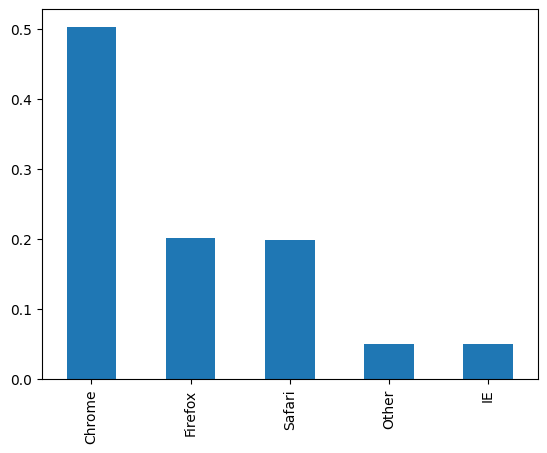

In [12]:
events['browser'].value_counts(normalize = True).plot(kind = 'bar')
plt.show()

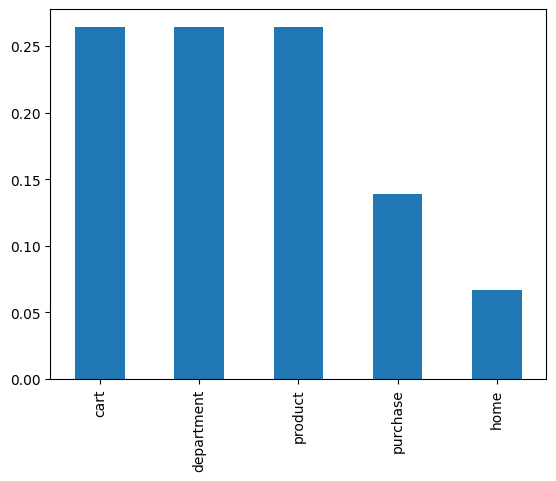

In [13]:
events['event_type'].value_counts(normalize = True).plot(kind = 'bar')
plt.show()

### Inference: The purchase percentage is relatively low, suggesting that many individuals are browsing products, adding them to their carts, but not completing the purchase.

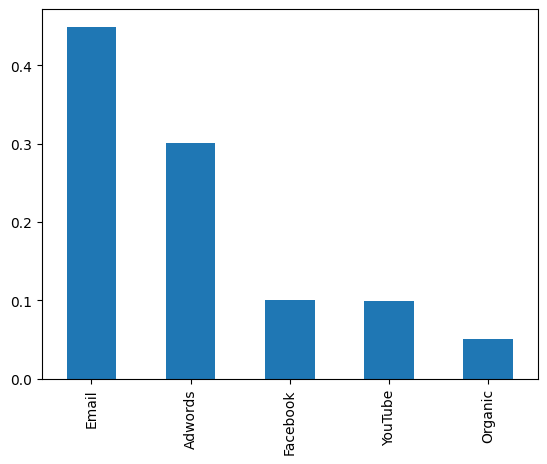

In [14]:
events['traffic_source'].value_counts(normalize = True).plot(kind = 'bar')
plt.show()

### High number of traffic is from emails and adwords

In [15]:
events['created_at'] = pd.to_datetime(events['created_at'])

# Analysing Session Duration of each session

In [16]:
session_duration = events.groupby('session_id')['created_at'].apply(lambda x: x.max() - x.min())

In [17]:
len(session_duration) == events.session_id.nunique()

True

In [18]:
session_duration = pd.DataFrame(session_duration).reset_index()

In [19]:
session_duration.rename(columns={'created_at': 'total_time'}, inplace=True)

In [20]:
session_duration['hours'] = session_duration['total_time'].apply(lambda x: x.total_seconds() / 3600)

In [21]:
session_duration.sort_values(by='total_time',ascending=False).head()

,session_id,total_time,hours
181589,ffb9f231-7c92-44bf-a4a6-72e6e3e99e61,4 days 00:28:43,96.478611
97348,8923b9b6-99a7-42d6-862c-bff0c5261e94,4 days 00:28:04,96.467778
146175,cdf858b0-75c8-4910-b84f-1e3bd1b3b607,4 days 00:27:39,96.460833
29022,28e0bfc8-175b-40ad-b8b9-4dc16e7bc90a,4 days 00:27:26,96.457222
92967,82f6d3d2-d7ce-4cd2-811b-8f886ded2451,4 days 00:27:14,96.453889


In [22]:
session_duration.describe()

,total_time,hours
count,181759,181759.000000
mean,1 days 01:00:36.925219658,25.010257
std,1 days 10:14:32.129534889,34.242258
min,0 days 00:00:16,0.004444
25%,0 days 00:06:00,0.100000
50%,0 days 00:09:14,0.153889
75%,2 days 00:12:32,48.208889
max,4 days 00:28:43,96.478611


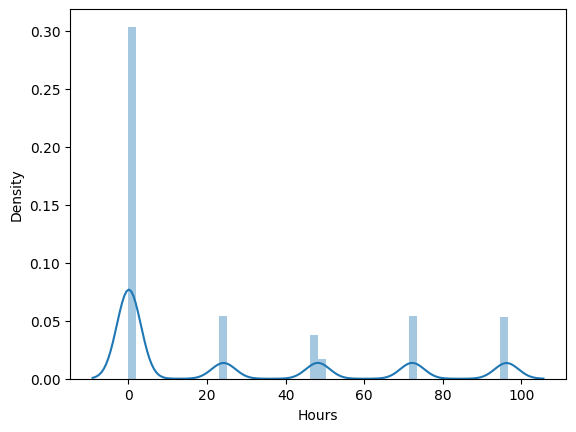

In [23]:
sns.distplot(session_duration['hours'])
plt.xlabel('Hours')
plt.ylabel('Density')
plt.show()

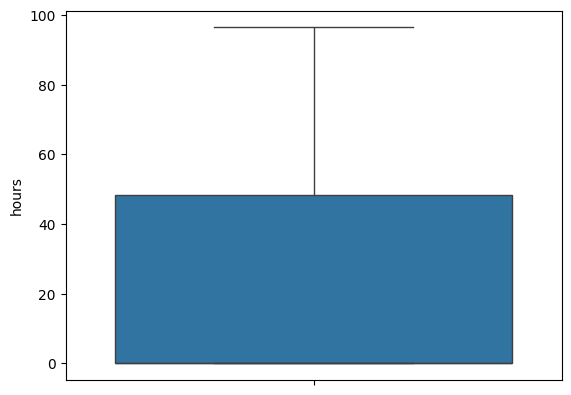

In [24]:
sns.boxplot(session_duration['hours'])
plt.show()

In [25]:
len(session_duration[session_duration['hours'] < 25 ]) * 100/ len(session_duration)

68.89067391435913

## Inference around 70% of whole sessions are only less than 25 hours

In [26]:
len(session_duration[session_duration['hours'] < 0.5]) * 100/ len(session_duration)

58.54015482039404

## Inference around 60% of whole sessions are only less than 0.5 hours

In [27]:
len(session_duration[session_duration['hours'] > 80]) * 100/ len(session_duration)

10.303203692802008

## Inference around 10% of whole sessions are only more than 10 hours

In [28]:
## Session duration have a hightly right skewness
session_duration['hours'].skew()

1.0055929400746904

In [29]:
session_duration['hours'].kurtosis()

-0.5142478528012613

# Anlysing session frequency

In [30]:
session_frequency = events.groupby('user_id')['session_id'].nunique()

In [31]:
session_frequency = pd.DataFrame(session_frequency).reset_index()

In [32]:
session_frequency.rename(columns={'session_id': 'frequency'}, inplace=True)

In [33]:
session_frequency.head(3)

,user_id,frequency
0,1.0,3
1,2.0,1
2,3.0,5


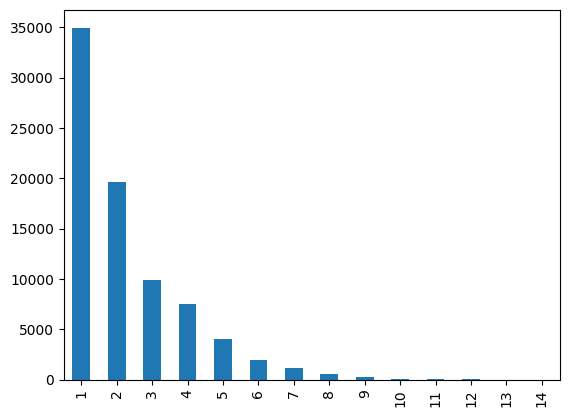

In [34]:
session_frequency['frequency'].value_counts().plot(kind = 'bar')
plt.show()

### The inference from a high number of users having a session frequency of 1 is that a significant portion of users visit the platform or website only once. This suggests a low level of engagement or interaction beyond the initial visit.

#### Lack of Retention Strategies
#### User Experience Issues
#### Users may have visited the platform to make a one-time transaction